# Золотарев Антон мФТиАД22

Рассмотрим одно исследование, хотя есть и ряд других, которые исследуют последствия различных предположений о механизмах распространения мнений. В исследовании Дефюэнта одним из ключевых является вопрос: каким образом мнения, которые изначально считаются крайними и маргинальными, могут стать социальной нормой? Несколько примеров в мировой истории показывают, что крупные сообщества могут более или менее внезапно радикализироваться из-за влияния первоначально небольшого меньшинства. С другой стороны, можно также найти множество примеров, когда происходит сильная биполяризация населения.

В модели Дефюэнта у агентов есть мнение (число между –1 и 1) и степень сомнения относительно их мнения, называемого неопределенностью. Диапазон мнения агента определяется как мнение ± неопределенность. Агенты взаимодействуют случайным образом. Когда они встречаются, один агент может влиять на другого, если их диапазоны мнений пересекаются. Если сегменты мнений не пересекаются, считается, что агенты настолько отличаются друг от друга в своих мнениях, что у них нет шансов повлиять друг на друга. Если сегменты мнений агентов i и j пересекаются, то агент j зависит от мнения агента i на сумму, пропорциональную разнице между их мнениями, умноженную на сумму пересечения и деленную на неопределенность агента i минус 1. Смысл этой формулы заключается в том, что неопределившиеся агенты влияют на других агентов меньше, чем агенты, уверенные в своем мнении.

Каждый агент начинает со случайного мнения и среднего уровня неопределенности, за исключением нескольких "экстремистов", тех, кто имеет самые положительные или отрицательные мнения и очень низкий уровень неопределенности. Постройте агентную модель и убедитесь, что в этих условиях экстремизм распространяется, и в конечном итоге симуляция достигает устойчивого состояния, когда все агенты присоединяются к экстремистам на том или другом конце континуума мнений. Без определенных экстремистов агенты приходят к среднему мнению. Таким образом, модель показывает, что несколько экстремистов с ярко выраженными мнениями могут оказать существенное влияние на мнение большинства.

http://jasss.soc.surrey.ac.uk/5/4/1.html

1. Реализовать модель парного взаимодействия. Реализовать модель все-со-всеми. (2 балла)
2. Оценить сходимость модели. (4 балла)
3. Реализовать ML модель предсказания числа кластеров (или иного показателя, введенного в п.2) (4 балла)

За реализацию модели на решетке (влияние на мнение в зависимости от близости ячеек агентов) будет отдельный бонус в зависимости от качества реализации. Продумайте корректирующий коэффициент влияния как функцию от расстояния между агентами. Возможно, вас наведет на умные мысли модификация k-means++, где начальные центроиды кластеров выбираются не случайно, а согласно схожей логике.

In [ ]:
!pip install Mesa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 7.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
from tqdm import tqdm
import itertools

from sklearn import metrics
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
%matplotlib inline

# Инициализация модели

In [ ]:
class CustomAgent(Agent):
    def __init__(self, unique_id, model, x, u, is_extremist=False):
        super().__init__(unique_id, model)
        self.x = x # мнение из диапазона [-1, 1]
        self.u = u # степень неуверенности
        self.is_extremist = is_extremist # индикатор, является ли агент экстремистом

    def step(self):
        if self.model.pairwise:
            if self.unique_id not in self.model.made_step:
                other_agent = self.random.choice(self.model.schedule.agents)
                while other_agent.unique_id in self.model.made_step: # чтобы не было повторных взаимодействий
                    other_agent = self.random.choice(self.model.schedule.agents)
                if not ((self.x + self.u <= other_agent.x - other_agent.u)
                    or (self.x - self.u >= other_agent.x + other_agent.u)): # проверяем, будет ли взаимодействие
                    h_ij = min(self.x + self.u, other_agent.x + other_agent.u) - max(self.x - self.u, other_agent.x - other_agent.u)
                    x_other_buf = other_agent.x
                    u_other_buf = other_agent.u
                    if not h_ij <= self.u: # (условие из статьи)
                        other_agent.x = other_agent.x + self.model.mu * (h_ij / self.u - 1) * (self.x - other_agent.x)
                        other_agent.u = other_agent.u + self.model.mu * (h_ij / self.u - 1) * (self.u - other_agent.u)
                        if other_agent.x > 1: # возвращаем корректное в рамках модели значение
                            other_agent.x = 1
                        elif other_agent.x < -1:
                            other_agent.x = -1
                    if not h_ij <= other_agent.u: # (условие из статьи)
                        self.x = self.x + self.model.mu * (h_ij / other_agent.u - 1) * (x_other_buf - self.x)
                        self.u = self.u + self.model.mu * (h_ij / u_other_buf - 1) * (u_other_buf - self.u)
                        if self.x > 1: # возвращаем корректное в рамках модели значение
                            self.x = 1
                        elif self.x < -1:
                            self.x = -1

                self.model.made_step += [self.unique_id, other_agent.unique_id]
                return _
        else:
            self.x_buf_arr = [] # списки для второго слагаемого (добавки к x_j и u_j), считаем для взаимодействия j с каждым агентом
            self.u_buf_arr = []
            for other_agent in self.model.schedule.agents: # пробегаем по всем агентам
                if other_agent.unique_id != self.unique_id: # кроме нашего
                    if not ((self.x + self.u <= other_agent.x - other_agent.u) # проверяем, будет ли взаимодействие (не пустое ли пересечение интервалов)
                        or (self.x - self.u >= other_agent.x + other_agent.u)):
                        h_ij = min(self.x + self.u, other_agent.x + other_agent.u) - max(self.x - self.u, other_agent.x - other_agent.u)
                        if h_ij > other_agent.u: # (условие из статьи)
                            x_new = self.model.mu * (h_ij / other_agent.u - 1) * (other_agent.x - self.x) # считаем добавки
                            u_new = self.model.mu * (h_ij / other_agent.u - 1) * (other_agent.u - self.u) # здесь mu = mu/(N-1)
                            if x_new > 1: # возвращаем корректное в рамках модели значение
                                x_new = 1
                            elif x_new < -1:
                                x_new = -1
                            self.x_buf_arr.append(x_new)
                            self.u_buf_arr.append(u_new)
                else:
                    continue
            # новые значения считаем как старый x_j + сумма добавок
            self.model.xs[self.unique_id] = self.x + sum(self.x_buf_arr)
            self.model.us[self.unique_id] = self.u + sum(self.u_buf_arr)
            return _

In [ ]:
class CustomModel(Model):
    def __init__(self, u=1.2, u_e=0.1, mu=0.5, p_e=0.25, delta=0, N=1000, pairwise=True):
        self.num_agents = N # число агентов N
        self.u = u # степень неуверенности обычных агентов
        self.u_e = u_e # степень неуверенности экстремистов
        self.mu = mu # степень чувствительности к чужому мнению
        self.p_e = p_e # доля экстремистов от N
        self.delta = delta # дельта из статьи
                           # (относительная разница между долей поз. и нег. экстр.)
        self.pairwise = pairwise # режим взаимодействия
        if self.pairwise == False:
            self.mu /= (self.num_agents - 1)

        self.schedule = RandomActivation(self) # добавим шедулер
        x_rand_gen = np.random.uniform(-1, 1, self.num_agents) # нагенерим рандомные x для инициализации агентов
        p_pos_div_p_neg = (1 + self.delta) / (1 - self.delta) # отношение p+/p-, полученное при раскрытии модуля
                                                              # в предположении, что положительных всегда не меньше
        N_neg_extr = int((self.num_agents * self.p_e) / (1 + p_pos_div_p_neg)) # число отриц. экстр.
        N_pos_extr = int(self.num_agents * self.p_e) - N_neg_extr # число полож. экстрем.
                        # формулы вывел на бумаге, еще пользуюсь соображением, что их сумма есть общее число экстрем.

        idxs_neg_extr = np.argpartition(x_rand_gen, N_neg_extr)[:N_neg_extr] # объявляем в качестве экстрем. хвосты слева и справа
        idxs_pos_extr = np.argpartition(x_rand_gen, -N_pos_extr)[-N_pos_extr:] # используя их числа, вычисленные ранее,
                                                                               # находим индексы экстремистов в массиве мнений x
        if self.pairwise:
            self.made_step = [] # массив, куда будем закидывать тех,
                                # кто поучаствовал на шаге в парном взаимодействии
        else:
            self.xs = [0 for _ in range(self.num_agents)] # списки для пересчитанных значений
            self.us = [0 for _ in range(self.num_agents)]
        # Инициализируем агентов и закидываем в шедулер
        for i, x in enumerate(x_rand_gen):
            if (i not in idxs_neg_extr) and (i not in idxs_pos_extr):
                a = CustomAgent(i, self, x, self.u)
                self.schedule.add(a)
            else:
                a = CustomAgent(i, self, x, self.u_e, True)
                self.schedule.add(a)

        self.datacollector = DataCollector(
            agent_reporters={"Opinions": "x"}) # для сбора данных по прогону модели

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        if self.pairwise:
            self.made_step = []
        else:
            for a in self.schedule.agents:
                a.x = self.xs[a.unique_id]
                a.u = self.us[a.unique_id]
            self.xs = [0 for _ in range(self.num_agents)]
            self.us = [0 for _ in range(self.num_agents)]

# Работа с моделью

## Парное взаимодействие

In [ ]:
model = CustomModel(N=200)
for i in range(225):
    model.step()

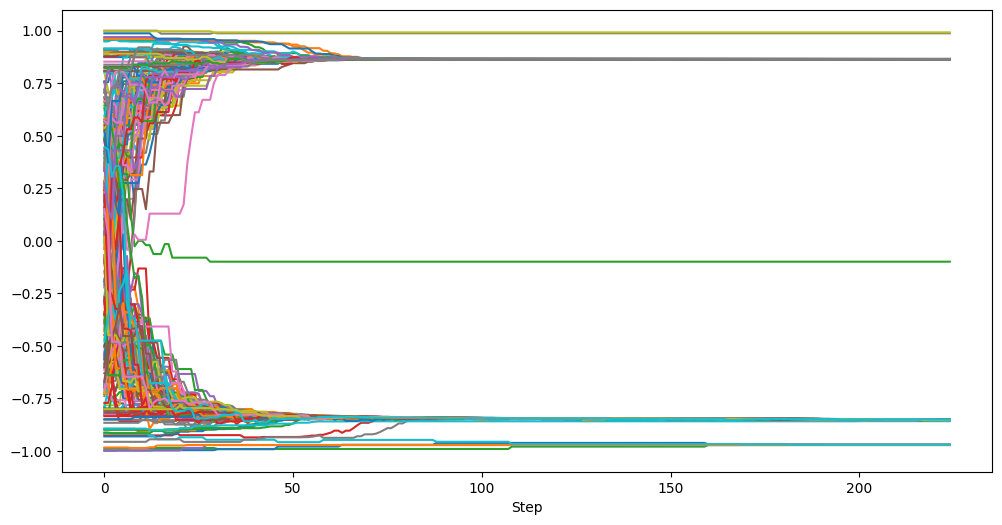

In [ ]:
opinion_data = model.datacollector.get_agent_vars_dataframe()
opinion_data.T.stack().T.plot(legend=False)
plt.show()

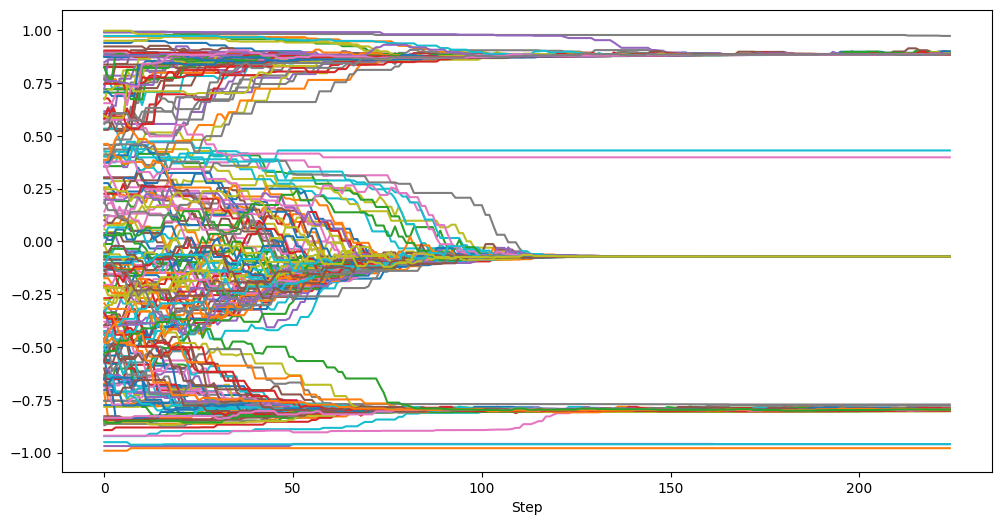

In [ ]:
model = CustomModel(p_e=0.2, N=200)
for i in range(225):
    model.step()
opinion_data = model.datacollector.get_agent_vars_dataframe()
opinion_data.T.stack().T.plot(legend=False, figsize=(12,6))
plt.show()

Визуально графики весьма схожи с графиками из статьи для таких же параметров, за исключением отсутствия сошедшихся к -0.5 траекторий и присутствием сошедшихся к -0.75

## "все со всеми"

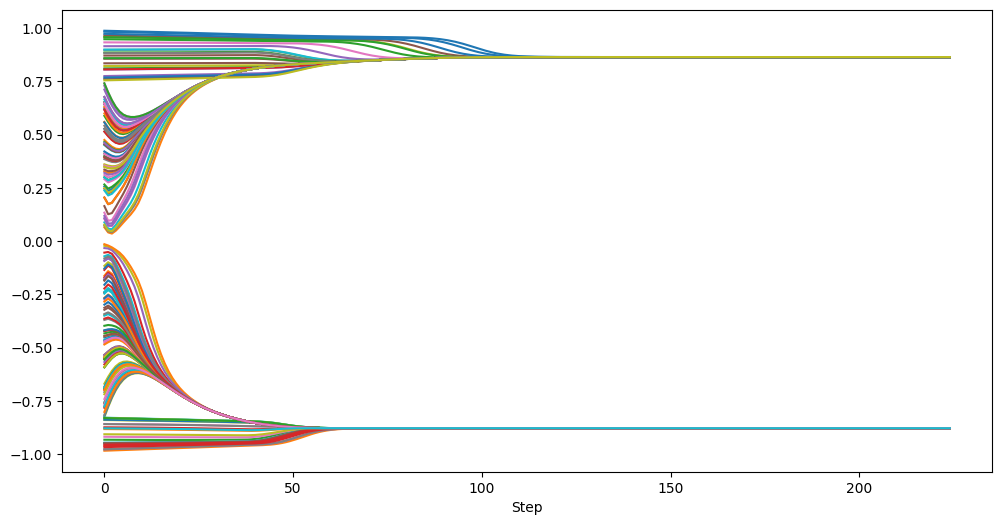

In [ ]:
model = CustomModel(N=200, pairwise=False)
for i in range(225):
    model.step()
opinion_data = model.datacollector.get_agent_vars_dataframe()
opinion_data.T.stack().T.plot(legend=False, figsize=(12,6))
plt.show() # как я понял, сглаживание происходит из-за усреднения

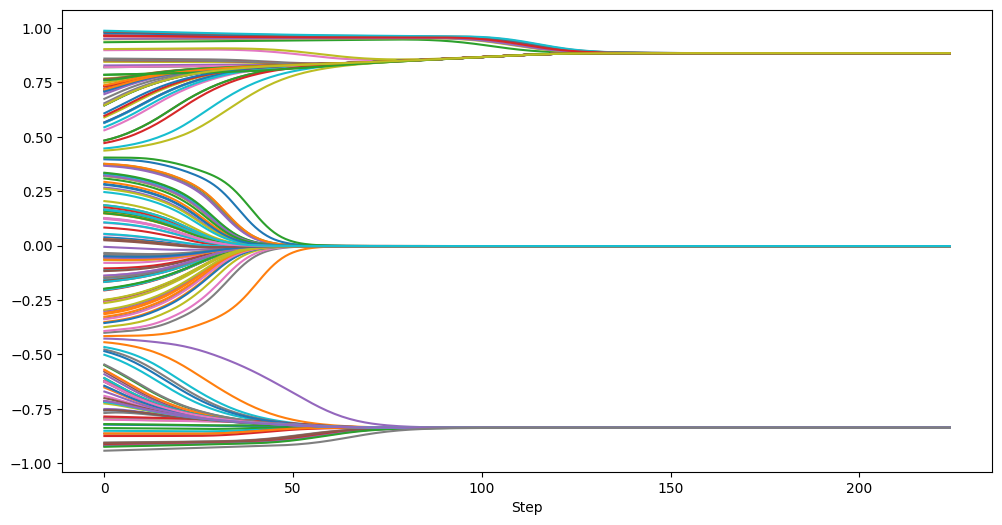

In [ ]:
model = CustomModel(u=0.4, _e=0.2, N=200, pairwise=False)
for i in range(225):
    model.step()
opinion_data = model.datacollector.get_agent_vars_dataframe()
opinion_data.T.stack().T.plot(legend=False, figsize=(12,6))
plt.show()

## Анализ сходимости

Сходимость проверяем так, как было предложено на семинаре:
* проверяем, чтобы у всех агентов изменения степени неуверенности за последние 5 шагов не выходили за пределы $\varepsilon$ относительно предыдущего значения

Наблюдается сходимость


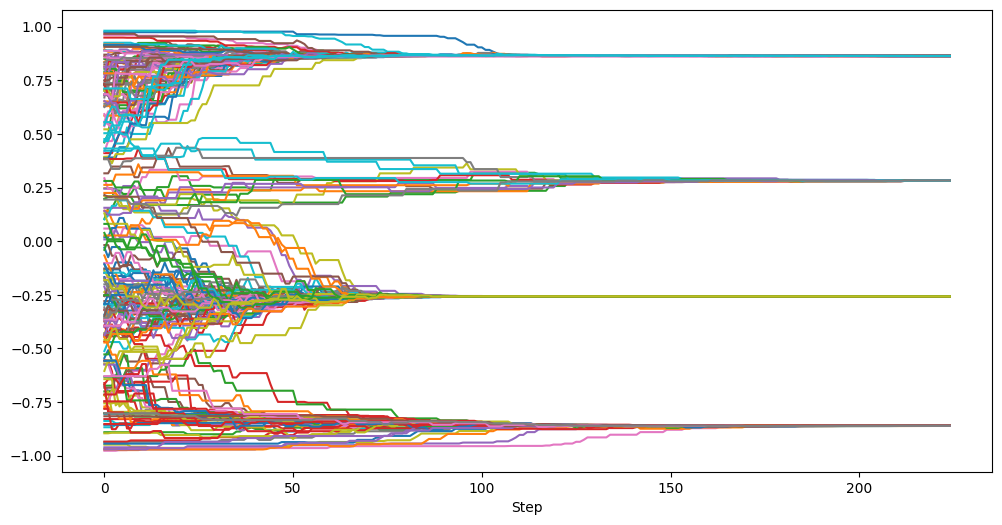

In [ ]:
model3_8 = CustomModel(u=0.4, u_e=0.1, mu=0.5, p_e=0.2, delta=0, N=200, pairwise=True)
for i in range(225):
    model3_8.step()
new_df = pd.DataFrame()
opinion_data_buf = model3_8.datacollector.get_agent_vars_dataframe()
for ag_id in list(opinion_data_buf.loc[0].index):
    new_df = pd.concat((new_df,
                        opinion_data_buf.loc[pd.IndexSlice[:, ag_id], :].droplevel(1).copy().rename(
                            columns={'Opinions':str(ag_id)})), axis=1)
if np.all(new_df.iloc[-6:].diff().dropna().apply(lambda x: x < 0.01)) == True:
    print('Наблюдается сходимость')
else:
    print('Модель не успела сойтись')
opinion_data3_8 = model3_8.datacollector.get_agent_vars_dataframe()
opinion_data3_8.T.stack().T.plot(legend=False, figsize=(12,6))
plt.show()

Мы установили факт сходимости в конце прогонки модели, теперь попробуем проверять сходимость на каждом шаге, начиная с 100-го (в силу отсутствия в предыдущих прогонах траекторий, сошедшихся ранее [оценено визуально])

In [ ]:
def convergence_check(model, eps=0.005):
    idx = pd.IndexSlice
    new_df = pd.DataFrame()
    opinion_data_buf = model.datacollector.get_agent_vars_dataframe()
    for ag_id in list(opinion_data_buf.loc[0].index):
        new_df = pd.concat((new_df,
                            opinion_data_buf.loc[idx[-15:, ag_id], :].droplevel(1).copy().rename(
                                columns={'Opinions':str(ag_id)})), axis=1)
    if np.all(new_df.iloc[-6:].diff().dropna().apply(lambda x: x < eps)) == True:
        return True

Чтобы установить, к чему сошлась модель воспользуемся индикатором типа сходимости $y = {p_{+}^\prime}^2 + {p_{-}^\prime}^2$ из статьи (пункт 4.1)

In [ ]:
def convergence_type(model, conv_c = 0.25):
  # определим склонность агента к экстремизму как значение, отличающиеся от 1 по модулю не более чем на 0.25, поскольку при меньшем диапазоне значения сильно различаются со статьёй
  p_plus = 0
  p_minus = 0
  for agent in model.schedule.agents:
    if agent.is_extremist == False:
      if agent.x >= 1 - conv_c:
        p_plus += 1
      elif agent.x <= -(1 - conv_c):
        p_minus += 1
      else:
        continue
  y = (p_plus / (model.num_agents * (1 - model.p_e))) ** 2 + (p_minus / (model.num_agents * (1 - model.p_e))) ** 2
  return y

In [ ]:
print(convergence_type(model3_8))

0.13613281249999998


Значение индикатора сходимости для модели с параметрами $u=0.4, u_e=0.1, \mu=0.5, p_e=0.2, \delta=0, N=200$ достаточно далеко от указнного в пункте 3.8 статьи (0.136 vs 0.03)

Посмотрим значение также для набора параметров из пункта 3.9 ($u=1.2, u_e=0.1, \mu=0.5, p_e=0.25, \delta=0, N=200$)

0.5022222222222222


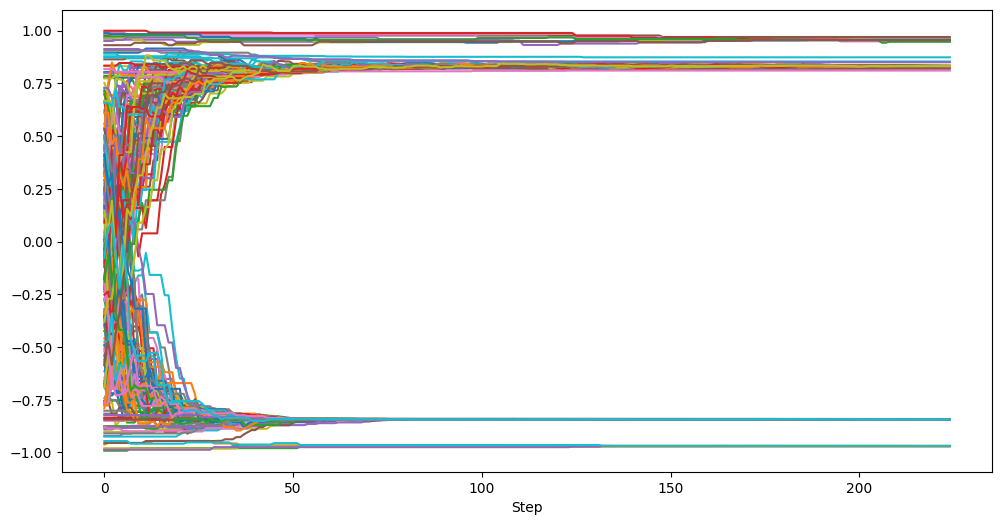

In [ ]:
model3_9 = CustomModel(u=1.2, u_e=0.1, mu=0.5, p_e=0.25, delta=0, N=200)
for i in range(225):
  model3_9.step()
opinion_data3_9 = model3_9.datacollector.get_agent_vars_dataframe()
opinion_data3_9.T.stack().T.plot(legend=False, figsize=(12,6))
print(convergence_type(model3_9))
plt.show()

Здесь уже значение индикатора весьма близко к обозначенным в статье 0.49

1.0


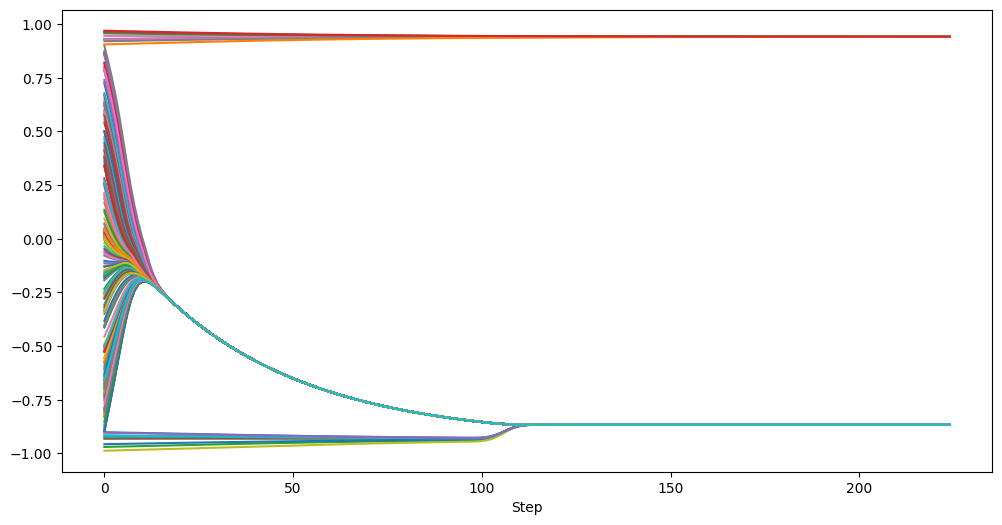

In [ ]:
model3_10 = CustomModel(u=1.4, u_e=0.1, mu=0.5, p_e=0.1, delta=0, N=200, pairwise=False)
for i in range(225):
    model3_10.step()
opinion_data3_10 = model3_10.datacollector.get_agent_vars_dataframe()
opinion_data3_10.T.stack().T.plot(legend=False, figsize=(12,6))
print(convergence_type(model3_10))
plt.show()

0.97 в статье vs 1.0 у нас (видимо, в статье для индикатора сходимости использовалось меньшее значение, чем полученные в нашем прогоне значения "экстремальности" мнений агентов)

# Генерация выборки для ML-модели

## Парное взаимодействие

Поскольку прогон модели для парного взаимодействия более быстрый, нагенерил сначала такую выборку, чтобы к дедлайну хоть что-то точно успелось. Также использовал здесь усечённое количество агентов для более быстрого прогона

In [ ]:
train_df = pd.DataFrame(columns=['u', 'u_e', 'mu', 'p_e', 'delta', 'y'])
p_e_lst = [0.05, 0.1, 0.2,  0.3]
u_lst = [ 0.4, 1, 1.2, 1.4]
u_e_lst = [ 0.05, 0.1, 0.15, 0.2]
delta_lst = [0,  0.2, 0.4, 0.5]
mu_lst = [0.1, 0.2, 0.4, 0.5]

lists = [u_lst, u_e_lst, mu_lst, p_e_lst, delta_lst]
prod_list = itertools.product(*lists)

In [ ]:
for el in prod_list:
    u, u_e, mu, p_e, delta = el
    model_test = CustomModel(u=u, u_e=u_e, mu=mu, p_e=p_e, delta=delta, N=200)
    for i in tqdm(range(500)):
        model_test.step()
    if convergence_check(model_test) == True:
        y = convergence_type(model_test)
        d = {'u':u, 'u_e':u_e, 'mu':mu, 'p_e':p_e,
                'delta':delta, 'y':y}
        train_df = train_df.append(d, ignore_index=True)

In [ ]:
train_df

,u,u_e,mu,p_e,delta,y
0,0.4,0.05,0.1,0.1,0.0,0.067160
1,0.4,0.05,0.1,0.1,0.2,0.148457
2,0.4,0.05,0.1,0.1,0.4,0.174599
3,0.4,0.05,0.1,0.1,0.5,0.071358
4,0.4,0.05,0.1,0.2,0.0,0.036406
...,...,...,...,...,...,...
829,1.4,0.20,0.5,0.2,0.5,0.020664
830,1.4,0.20,0.5,0.3,0.0,0.529490
831,1.4,0.20,0.5,0.3,0.2,0.502551
832,1.4,0.20,0.5,0.3,0.4,0.107959


In [ ]:
train_df.to_csv('/content/drive/MyDrive/imit_hw3/ml_train.csv', index=False)

## Все со всеми

Попробовал прогнать все гиперпараметры точно так, как было в итоговом эксперименте из статьи (для которого они потом рисовали сетки зависимости индикатора экстремизма от перебранных гиперпараметров), но полный проход по всем 8400 вариациям гиперпараметров потребовал бы порядка 2 полных дней, поэтому ML-модель "все-со-всеми" будет обучена на неполной выборке, который успела обучиться к 22-54 дня дедлайна :)

In [ ]:
df_all_to_all = pd.DataFrame(columns=['u', 'u_e', 'mu', 'p_e', 'delta', 'y'])
p_e = [0.025, 0.5, 0.1, 0.15, 0.2, 0.25, 0.3]
u = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
u_e = [0.05, 0.1, 0.15, 0.2]
delta = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
mu = [0.1, 0.2, 0.3, 0.4, 0.5]

prod_list = itertools.product(*[p_e, u, u_e, delta, mu])
prod_list = list(prod_list)
print(len(p_e)*len(u)*len(u_e)*len(delta)*len(mu))

8400


In [ ]:
list(prod_list)

In [ ]:
df_all_to_all = pd.read_csv('/content/drive/MyDrive/imit_hw3/df_all_to_all336.csv')
df_all_to_all

,u,u_e,mu,p_e,delta,y
0,0.025,0.2,0.05,0.0,0.1,0.0
1,0.025,0.2,0.05,0.0,0.2,0.0
2,0.025,0.2,0.05,0.0,0.3,0.0
3,0.025,0.2,0.05,0.0,0.4,0.0
4,0.025,0.2,0.05,0.0,0.5,0.0
...,...,...,...,...,...,...
1738,0.500,1.0,0.15,0.2,0.5,0.0
1739,0.500,1.0,0.15,0.3,0.1,0.0
1740,0.500,1.0,0.15,0.3,0.2,0.0
1741,0.500,1.0,0.15,0.3,0.3,0.0


In [ ]:
df_all_to_all.describe()

,u,u_e,mu,p_e,delta,y
count,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000,1743.000000
mean,0.174340,0.937808,0.122806,0.249627,0.299828,0.007196
std,0.220595,0.554772,0.055990,0.170427,0.141157,0.026397
min,0.025000,0.200000,0.050000,0.000000,0.100000,0.000000
25%,0.025000,0.400000,0.050000,0.100000,0.200000,0.000000
50%,0.025000,0.800000,0.100000,0.200000,0.300000,0.000000
75%,0.500000,1.400000,0.150000,0.400000,0.400000,0.004133
max,0.500000,2.000000,0.200000,0.500000,0.500000,0.318418


In [ ]:
df_all_to_all.y.describe()

count    1451.000000
mean        0.008644
std         0.028716
min         0.000000
25%         0.000000
50%         0.000000
75%         0.006602
max         0.318418
Name: y, dtype: float64

In [ ]:
for i, el in enumerate(prod_list):
  if i==0:
    print(prod_list[i])
  else:
    break

(0.025, 0.2, 0.05, 0, 0.1)


In [ ]:
with tqdm(total=8400-2000) as pbar:
  k=2000
  for i in range(len(prod_list)-2000):
    k += 1
    u, u_e, mu, p_e, delta = prod_list[i+2000]
    model_test = CustomModel(u=u, u_e=u_e, mu=mu, p_e=p_e, delta=delta, N=200, pairwise=False)
    for j in range(200):
      model_test.step()
    if convergence_check(model_test) == True:
      y = convergence_type(model_test)
      d = {'u':u, 'u_e':u_e, 'mu':mu, 'p_e':p_e,
              'delta':delta, 'y':y}
      df_all_to_all = df_all_to_all.append(d, ignore_index=True)
      df_all_to_all.to_csv('/content/drive/MyDrive/imit_hw3/df_all_to_all'+str(k)+'.csv', index=False)
    pbar.update(1)

 17%|█▋        | 1110/6400 [6:33:29<31:15:15, 21.27s/it]


KeyboardInterrupt: ignored

In [ ]:
df_all_to_all.to_csv('/content/drive/MyDrive/imit_hw3/df_all_to_all.csv', index=False)

# Обучение модели для парного взаимодействия



In [ ]:
ml_train = pd.read_csv('/content/drive/MyDrive/imit_hw3/ml_train.csv')
ml_train

,u,u_e,mu,p_e,delta,y
0,0.4,0.05,0.1,0.1,0.0,0.067160
1,0.4,0.05,0.1,0.1,0.2,0.148457
2,0.4,0.05,0.1,0.1,0.4,0.174599
3,0.4,0.05,0.1,0.1,0.5,0.071358
4,0.4,0.05,0.1,0.2,0.0,0.036406
...,...,...,...,...,...,...
829,1.4,0.20,0.5,0.2,0.5,0.020664
830,1.4,0.20,0.5,0.3,0.0,0.529490
831,1.4,0.20,0.5,0.3,0.2,0.502551
832,1.4,0.20,0.5,0.3,0.4,0.107959


In [ ]:
y = ml_train['y']
X = ml_train.drop(columns=['y'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [ ]:
def calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred):
  print("Train RMSE = %.4f" % metrics.mean_squared_error(y_train, y_train_pred, squared=False))
  print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred, squared=False))
  print("Test MAPE = %.4f" % metrics.mean_absolute_percentage_error(y_test, y_test_pred))
  print("Test R^2 = %.4f" % metrics.r2_score(np.array(y_test), y_test_pred))

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
# make predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 0.2611
Test RMSE = 0.2781
Test MAPE = 30332288712573.7500
Test R^2 = 0.2205


Плохо, попробуем Ридж-регрессию

### Ridge [Бейзлайн]

In [ ]:
model = Ridge().fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 0.2612
Test RMSE = 0.2781
Test MAPE = 29764649700709.9102
Test R^2 = 0.2206


* RMSE, исходя из вариации целевой переменной, велика и на трейне, и на тесте
* $𝑅^2$ мал
* идём дальше

### Случайный лес

In [ ]:
rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 0.0827
Test RMSE = 0.2271
Test MAPE = 34768882866319.3164
Test R^2 = 0.4802


* RMSE снизился на 0.04
* $R^2$ вырос почти в 2 раза
* остаёмся не совсем довольными и идём дальше, пробуя отобрать оптимальные гиперпараметры для случайного леса

In [ ]:
param_grid = {
    'max_depth': [50, 75, 100, 200],
    'max_features': [1, 2, 4, 8],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500, 700]
}

rf_grid = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, scoring="neg_root_mean_squared_error",
                          cv = 3, n_jobs = -1)

In [ ]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'max_depth': 200, 'max_features': 2, 'min_samples_split': 8, 'n_estimators': 300}


In [ ]:
rf_cv = RandomForestRegressor(n_estimators=300, max_features=2, max_depth=200, min_samples_split=8)
rf_cv.fit(X_train, y_train)
y_train_pred = rf_cv.predict(X_train)
y_test_pred = rf_cv.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 0.1702
Test RMSE = 0.2338
Test MAPE = 31083427508255.7734
Test R^2 = 0.4492


Как-то плохо перебирал гиперпараметры, раз дефолтные оказались лучше подобранных по всем рассматриваемым метрикам (как будто недообучился лесок наш)

### Градиентный бустинг

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, nthread=4, seed=42)
xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 0.2007
Test RMSE = 0.2340
Test MAPE = 28797101107086.5273
Test R^2 = 0.4483


In [ ]:
xgb_model = xgb.XGBRegressor(nthread=4, seed=42)
param_grid1 = {
    'n_estimators': [50, 100, 200, 400],
    'learning_rate': [0.001, 0.01, 0.025, 0.05],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'max_depth': [2, 4, 8],
    'reg_lambda': [None, 0.9, 1.0, 1.1],
    'reg_alpha': [None, 0.9, 1.0, 1.1],
    'subsample': [0.3, 0.5, 0.7]
}

clf = GridSearchCV(xgb_model, param_grid=param_grid1, scoring='neg_root_mean_squared_error', n_jobs=-1)
clf.fit(x_train, y_train)
print('Best params:', clf.best_params_)
print('Best score:', -clf.best_score_)

Best params: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 400, 'reg_alpha': 0.9, 'reg_lambda': 0.9, 'subsample': 0.7}
Best score: 0.23477891930684078


In [ ]:
xgb_best = xgb.XGBRegressor(**{'learning_rate': 0.05, 'max_depth': 4,
                               'n_estimators': 400, 'reg_alpha': 0.9, 'reg_lambda': 0.9, 'subsample': 0.7})
xgb_best.fit(X_train, y_train)
y_train_pred = xgb_best.predict(X_train)
y_test_pred = xgb_best.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 0.1714
Test RMSE = 0.2263
Test MAPE = 28193100233951.6719
Test R^2 = 0.4841


Всё ещё запредельное значение MAPE, недовольство!!!

# Обучение модели для модели "все со всеми"



In [ ]:
ml_train = pd.read_csv('/content/drive/MyDrive/imit_hw3/df_all_to_all3110.csv')
ml_train

,u,u_e,mu,p_e,delta,y
0,0.025,0.2,0.05,0.0,0.1,0.000000
1,0.025,0.2,0.05,0.0,0.2,0.000000
2,0.025,0.2,0.05,0.0,0.3,0.000000
3,0.025,0.2,0.05,0.0,0.4,0.000000
4,0.025,0.2,0.05,0.0,0.5,0.000000
...,...,...,...,...,...,...
2827,0.100,1.2,0.20,0.3,0.1,0.000000
2828,0.100,1.2,0.20,0.3,0.2,0.000000
2829,0.100,1.2,0.20,0.3,0.3,0.000459
2830,0.100,1.2,0.20,0.3,0.4,0.001837


In [ ]:
ml_train.y.describe()

count    2832.000000
mean        0.005612
std         0.021226
min         0.000000
25%         0.000000
50%         0.000000
75%         0.003265
max         0.318418
Name: y, dtype: float64

Сразу видим, что то ли налажали в функции индикатора сходимости, то ли сетка успевших перебраться гиперпараметров была выстроена так, что более 50% значений - нули. Кажется, качество будет высоким, но несправедливо высоким...

In [ ]:
y = ml_train['y']
X = ml_train.drop(columns=['y'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
# make predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 0.0212
Test RMSE = 0.0186
Test MAPE = 17770651092598.0234
Test R^2 = 0.0560


### Градиентный бустинг

In [ ]:
xgb_model = xgb.XGBRegressor(seed=10)
xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 0.0055
Test RMSE = 0.0152
Test MAPE = 4270744168062.3652
Test R^2 = 0.3704


In [ ]:
xgb_model = xgb.XGBRegressor(nthread=4, seed=42)

param_grid1 = {
    'n_estimators': [50, 100, 200, 400],
    'learning_rate': [0.001, 0.01, 0.025, 0.05],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'max_depth': [2, 4, 8],
    'subsample': [0.3, 0.5, 0.7]
}

clf = GridSearchCV(xgb_model, param_grid=param_grid1, scoring='neg_root_mean_squared_error', n_jobs=-1)
clf.fit(X_train, y_train)
print('Best params:', clf.best_params_)
print('Best score:', clf.best_score_)

Best params: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.7}
Best score: 0.014999569651473001


In [ ]:
xgb_best = xgb.XGBRegressor(**{'learning_rate': 0.05, 'max_depth': 4,
                               'n_estimators': 400, 'subsample': 0.7})
xgb_best.fit(X_train, y_train)
y_train_pred = xgb_best.predict(X_train)
y_test_pred = xgb_best.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 0.0105
Test RMSE = 0.0122
Test MAPE = 5374163013934.8643
Test R^2 = 0.5941


Всё ещё запредельное значение MAPE при весьма высоком $R^2$. Видимо, за последний пункт задания точно не стоит ожидать полный балл

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 12.0 MB/s eta 0:00:00


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


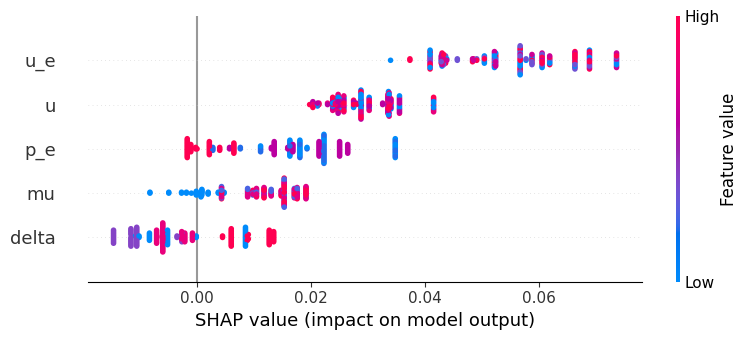

In [ ]:
import shap
Xd = xgb.DMatrix(X_test, label=y_test)
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(Xd)
shap.summary_plot(shap_values, X_test)


Видим, что большинство значений индикатора ушло в 0 именно из-за низких значений $\mu$ и $\delta$, тогда как $u_e$ и $u$ наибольшим образом влияет на повышение экстримизма в сообществе.

Таким образом, исходя из проведённых экспериментов, можем сделать вывод, что в рамках общины, где все взаимодействуют со всеми, экстремизм будет развиваться там, где у "нулевого" экстремиста отсутствует неуверенность в собственных суждений, при этом у остального обещства эта неуверенность весьма высока